In [5]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

### 1) Classical Monte Carlo

In [6]:
def classical_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                          risk_free_interest_rate, dividend_rate, 
                          volatility, option_type, time_steps_count, samples_count):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    time_step = time_to_maturity/time_steps_count
    
    weights = np.random.standard_normal(size=(samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * np.sqrt(time_step)  

    stock_prices = initial_stock_price * np.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    # price_differences[price_differences < 0] = 0
    
    price_differences = np.clip(price_differences, a_min=0, a_max=None)
    
    option_prices = price_differences * np.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices

In [31]:
def arithmetic_asian_option_price(initial_stock_price, strike_price, time_to_maturity, 
                                  risk_free_interest_rate, 
                                  volatility, option_type, time_steps_count, samples_count):
    
    S = initial_stock_price
    K = strike_price
    T = time_to_maturity
    r = risk_free_interest_rate
    # dividend_rate, 
    sigma = volatility
    CallPut = option_type 
    N = time_steps_count 
    M = samples_count
            
            
    '''
    Simple Monte Carlo pricing for arithmetic Asian options
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            N - number of time steps for each MC path
        r - Risk-free interest rate     M - number of simulated paths
    
    Returns the simulated price of an arithmetic Asian-style call or put option and the associated 
    95% confidence interval of the estimate.
    '''
    sims = np.zeros(M) # vector of simulated values
    t = np.linspace(0,T,N+1)
    dt = T/N
    
    for i in range(M):      
        W = [0] + list(np.random.standard_normal(size=N))
        W = np.cumsum(W)*np.sqrt(dt)
        St = S*np.exp((r-0.5*sigma**2)*t - sigma*W)
        sims[i] = np.sum(St)
        
    sims = sims/(N+1)
    if CallPut == 'Call':
        sims = sims - K;    sims[sims < 0] = 0
    elif CallPut == 'Put':
        sims = K - sims;    sims[sims < 0] = 0
    
    sims = sims*np.exp(-r*T)
    mu_hat = np.mean(sims)
    sigma_hat = np.sqrt(np.sum((sims-mu_hat)**2)/(M-1))    
    
    # CI = [mu_hat - 1.96*sigma_hat/np.sqrt(M), mu_hat + 1.96*sigma_hat/np.sqrt(M)]
    
    return mu_hat

In [32]:
def plot_asset_prices(initial_asset_prices, volatilities, asset_prices_meshgrid,
                      elevation=10, initial_azimuth=230):

    initial_asset_prices_grid, volatilities_grid = np.meshgrid(initial_asset_prices, volatilities)

    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_asset_prices_grid,
                              volatilities_grid,
                              asset_prices_meshgrid.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=False)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial Asset Price')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Asset Price', rotation=90)
    
    plt.show()

In [33]:
# Fixed Parameters

T = time_to_maturity = 1

q = dividend_rate = 0.05
r = risk_free_interest_rate = 0.02

time_steps_count = 300

strike_price = 1000

samples_count = 100

CallPut = option_type = 'Call'

#### Classical Monte Carlo

In [34]:
DATASET_FILE = 'generated_prices/asian_option_prices.csv'
# DATASET_FILE = 'asian_option_prices.csv'

GRID_STEP = 3

initial_stock_prices = np.linspace(0, 10000, 101)
volatilities = np.linspace(0, 1.0, 101)

initial_stock_prices = initial_stock_prices[::GRID_STEP]
volatilities = volatilities[::GRID_STEP]


fields_count = 3

option_prices_shape = (len(initial_stock_prices) * len(volatilities), fields_count)

# option_prices = np.zeros(option_prices_shape)

option_prices = []

option_prices_meshgrid_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = np.zeros(option_prices_meshgrid_shape)


np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,volatility,option_price',
           comments='')

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1    
)    

for initial_stock_price_index, initial_stock_price in enumerate(simulation_tracker):

    for volatility_index, volatility in enumerate(volatilities):

        # sampled_option_prices = classical_monte_carlo(
        #     initial_stock_price=initial_stock_price, 
        #     strike_price=strike_price,
        #     time_to_maturity=time_to_maturity, 
        #     risk_free_interest_rate=risk_free_interest_rate,
        #     dividend_rate=dividend_rate, 
        #     volatility=volatility, 
        #     option_type=option_type, 
        #     time_steps_count=time_steps_count,
        #     samples_count=samples_count
        # )
        
        sampled_option_prices = arithmetic_asian_option_price(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
        
        option_price = sampled_option_prices.mean()
        
        option_prices.append([initial_stock_price, volatility, option_price])
               
        option_prices_meshgrid[initial_stock_price_index, volatility_index] = option_price
        
with open(DATASET_FILE, 'ab') as dataset_file:
    np.savetxt(dataset_file, option_prices, fmt=('%d', '%f', '%f'), delimiter=',')

Simulating: 100%|█████████████████████████████████████████████████████| 34/34 [00:05<00:00,  6.44simulation/s]


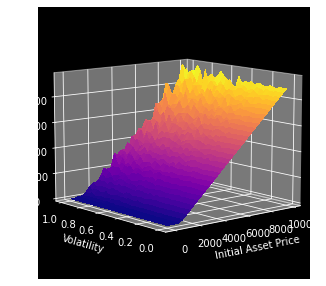

In [35]:
plot_asset_prices(initial_stock_prices, volatilities, option_prices_meshgrid)

### 2) JAX Initialization

In [ ]:
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [13]:
import os
import time
import numpy as np

# JAX

import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)


# Host CPUs

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(1, 3)))

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=4, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=5, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=6, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=7, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=8, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=9, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=10, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=11, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=12, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=13, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=14, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=15, pro

In [14]:
def jax_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                    risk_free_interest_rate, dividend_rate, 
                    volatility, option_type, time_steps_count, samples_count,
                    randomization_key):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    time_step = time_to_maturity/time_steps_count
    
    weights = jax.random.normal(key=randomization_key, 
                                shape=(samples_count, time_steps_count))
    
    # weights = jnp.zeros((samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * jnp.sqrt(time_step)  

    stock_prices = initial_stock_price * jnp.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                 + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    price_differences = jnp.clip(price_differences, a_min=0)
    
    option_prices = price_differences * jnp.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices


# def meanify(function):
    
#     def function_mean(*args, **kwargs):
        
#         function_result = function(*args, **kwargs)
        
#         mean_result = function_result.mean()
        
#         return mean_result
    
#     return function_mean
    

def jax_monte_carlo_mean(initial_stock_price, strike_price, time_to_maturity, 
                         risk_free_interest_rate, dividend_rate, 
                         volatility, option_type, time_steps_count, samples_count,
                         randomization_key):
    
    samples = jax_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                              risk_free_interest_rate, dividend_rate, 
                              volatility, option_type, time_steps_count, samples_count,
                              randomization_key)
    
    result = samples.mean()
    
    return result


def classical_monte_carlo_mean(initial_stock_price, strike_price, time_to_maturity, 
                               risk_free_interest_rate, dividend_rate, 
                               volatility, option_type, time_steps_count, samples_count):
    
    samples = classical_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                                    risk_free_interest_rate, dividend_rate, 
                                    volatility, option_type, time_steps_count, samples_count)
    
    result = samples.mean()
    
    return result



# Fixed Parameters

T = time_to_maturity = 1

q = dividend_rate = 0.05
r = risk_free_interest_rate = 0.02

CallPut = option_type = 'Call'

### 3) JAX JIT

#### 3.1) Standalone Jitted Monte Carlo

In [15]:
jitted_monte_carlo = jax.jit(jax_monte_carlo, 
                             static_argnames=('samples_count' , 
                                              'time_steps_count',
                                              'option_type'))

jitted_monte_carlo_mean = jax.jit(jax_monte_carlo_mean, 
                                  static_argnames=('samples_count' , 
                                                   'time_steps_count',
                                                   'option_type'))

In [21]:
# Parameters

initial_stock_price = 5000
volatility = 0.8

samples_count = 100000
# samples_count = 20

time_steps_count = 300

strike_price = 1000

randomization_key = jax.random.PRNGKey(seed=100)


start_time = time.time()

sampled_option_prices = jitted_monte_carlo(
    initial_stock_price=initial_stock_price, 
    strike_price=strike_price,
    time_to_maturity=time_to_maturity, 
    risk_free_interest_rate=risk_free_interest_rate,
    dividend_rate=dividend_rate, 
    volatility=volatility, 
    option_type=option_type, 
    time_steps_count=time_steps_count,
    samples_count=samples_count,
    randomization_key=randomization_key
)

end_time = time.time()

duration = end_time - start_time

print(f"duration: {duration:.02f} s.")

print("sampled_option_prices:", sampled_option_prices)

duration: 0.58 s.
sampled_option_prices: [7793.97878268 2953.73858521    0.         ... 1928.75882309    0.
 1006.43158905]


#### 3.2) Standalone Classical Monte Carlo

In [22]:
start_time = time.time()

sampled_option_prices = classical_monte_carlo(
    initial_stock_price=initial_stock_price, 
    strike_price=strike_price,
    time_to_maturity=time_to_maturity, 
    risk_free_interest_rate=risk_free_interest_rate,
    dividend_rate=dividend_rate, 
    volatility=volatility, 
    option_type=option_type, 
    time_steps_count=time_steps_count,
    samples_count=samples_count
)

end_time = time.time()

duration = end_time - start_time

print(f"duration: {duration:.02f} s.")

print("sampled_option_prices:", sampled_option_prices)

duration: 0.71 s.
sampled_option_prices: [1654.86069178 3990.04409446 3122.64996318 ... 8517.12362647 9339.4154391
 3619.95121906]


### 4) 1D Parallelization - VMap and PMap

#### 4.1) VMap

In [25]:
# initial_stock_prices = jnp.array([1000, 5000])

initial_stock_prices = np.linspace(0, 10000, 11)

# volatilities = np.linspace(0, 1.0, 101)


start_time = time.time()

vmapped_monte_carlo = jax.vmap(jax_monte_carlo,
                               # static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

vmapped_result = vmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_vmapped_result = vmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_vmapped_result.shape:", evaluated_vmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_vmapped_result.shape: (11, 100000)
duration: 0.99 s.


#### 4.2) VMap - JIT

In [28]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(jitted_monte_carlo,
                               # static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

vmapped_result = vmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_vmapped_result = vmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_vmapped_result.shape:", evaluated_vmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_vmapped_result.shape: (11, 100000)
duration: 0.37 s.


#### 4.3) PMap - No previous JIT

In [30]:
# initial_stock_prices = jnp.array([1000, 5000])

initial_stock_prices = np.linspace(0, 10000, 11)

# volatilities = np.linspace(0, 1.0, 101)


start_time = time.time()

pmapped_monte_carlo = jax.pmap(jax_monte_carlo,
                               static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

pmapped_result = pmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result.shape:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_pmapped_result.shape: (11, 100000)
duration: 7.83 s.


#### 4.4) PMap - Previous JIT

In [32]:
start_time = time.time()

pmapped_monte_carlo = jax.pmap(jitted_monte_carlo,
                               static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

pmapped_result = pmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result.shape:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_pmapped_result.shape: (11, 100000)
duration: 0.24 s.


### 5) 2D Parallelization

In [49]:
samples_count = 10000

STOCK_PRICE_STEPS = 16
VOLATILITY_STEPS = 16

initial_stock_prices = np.linspace(0, 10000, STOCK_PRICE_STEPS)

volatilities = np.linspace(0, 1.0, VOLATILITY_STEPS)

initial_stock_prices_count = len(initial_stock_prices)
volatilities_count = len(volatilities)


# Randomization Keys

random_seed = np.random.randint(1000)

initial_randomization_key = jax.random.PRNGKey(seed=random_seed)

keys_count = volatilities_count * initial_stock_prices_count

randomization_keys_vector = jax.random.split(initial_randomization_key, keys_count)

randomization_keys = randomization_keys_vector.reshape(volatilities_count, 
                                                       initial_stock_prices_count, 2)

#### 5.1) VMap and VMap - No previous JIT

In [ ]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(
    jax_monte_carlo_mean,
    # jitted_monte_carlo_mean,
    in_axes=(0, None, None, None, None, None, None, None, None, 0)
)

second_vmapped_monte_carlo = jax.vmap(
    vmapped_monte_carlo,
    in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

second_vmapped_result = second_vmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatilities, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_keys
    
)

evaluated_second_vmapped_result = second_vmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_second_vmapped_result.shape:", evaluated_second_vmapped_result.shape)

print(f"duration: {duration:.02f} s.")

2023-01-30 13:25:27.955411: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 57.22GiB (rounded to 61440000000)requested by op 
2023-01-30 13:25:27.955650: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2023-01-30 13:25:27.955812: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2163] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 61440000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     2.0KiB
              constant allocation:         0B
        maybe_live_out allocation:   57.22GiB
     preallocated temp allocation:  143.05GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  200.27GiB
              total

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 61440000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     2.0KiB
              constant allocation:         0B
        maybe_live_out allocation:   57.22GiB
     preallocated temp allocation:  143.05GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  200.27GiB
              total fragmentation:   28.61GiB (14.29%)
Peak buffers:
	Buffer 1:
		Size: 57.22GiB
		Operator: op_name="jit(_normal)/jit(main)/mul" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: f64[16,16,100000,300]
		==========================

	Buffer 2:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: custom-call
		Shape: u32[16,16,30000000]
		==========================

	Buffer 3:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: custom-call
		Shape: u32[16,16,30000000]
		==========================

	Buffer 4:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: u32[16,16,30000000]
		==========================

	Buffer 5:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: u32[16,16,30000000]
		==========================

	Buffer 6:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: u32[16,16,30000000]
		==========================

	Buffer 7:
		Size: 2.0KiB
		Entry Parameter Subshape: u32[16,16,2]
		==========================

	Buffer 8:
		Size: 16B
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: custom-call
		Shape: (u32[16,16,30000000], u32[16,16,30000000])
		==========================

	Buffer 9:
		Size: 16B
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: (u32[16,16,30000000], u32[16,16,30000000])
		==========================



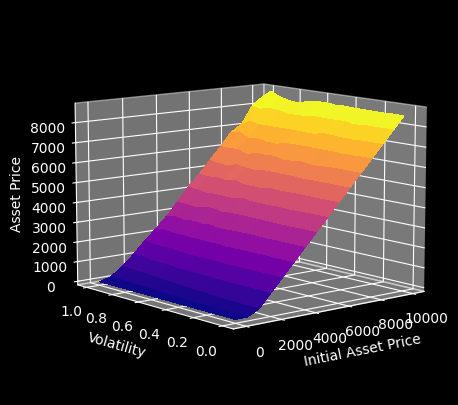

In [38]:
plot_asset_prices(initial_stock_prices, volatilities, evaluated_second_vmapped_result.T)

#### 5.2) PMap and VMap - No previous JIT

In [ ]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(
    jax_monte_carlo_mean,
    # jitted_monte_carlo_mean,
    in_axes=(0, None, None, None, None, None, None, None, None, 0)
)

pmapped_monte_carlo = jax.pmap(
    vmapped_monte_carlo,
    static_broadcasted_argnums=(6, 7, 8),
    in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

pmapped_result = pmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatilities, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_keys
    
)

evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_pmapped_result: (16, 16)
duration: 0.26 s.


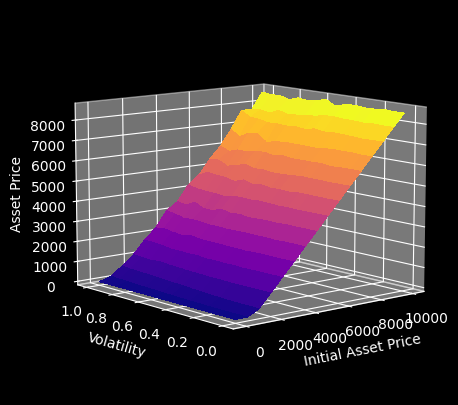

In [ ]:
plot_asset_prices(initial_stock_prices, volatilities, evaluated_pmapped_result.T)

#### 5.3) Classical Monte Carlo Loop

In [ ]:
start_time = time.time()

classical_results = np.zeros(shape=(len(initial_stock_prices),
                                    len(volatilities)))

for volatility_index, volatility in enumerate(volatilities):
    
    # print("volatility:", volatility)
    
    for initial_stock_price_index, initial_stock_price in enumerate(initial_stock_prices):
        
        # print("  initial_stock_price:", initial_stock_price)
        
        # continue

        classical_result = classical_monte_carlo_mean(

            initial_stock_price, 
            strike_price,
            time_to_maturity, 
            risk_free_interest_rate,
            dividend_rate, 
            volatility, 
            option_type, 
            time_steps_count,
            samples_count

        )
        
        classical_results[initial_stock_price_index, volatility_index] = classical_result
        
    elapsed_time = time.time() - start_time

    # print(f"elapsed_time: {elapsed_time:.02f} s.")
        

end_time = time.time()

duration = end_time - start_time

print("classical_results:", classical_results.shape)

print(f"duration: {duration:.02f} s.")

classical_results: (16, 16)
duration: 8.39 s.


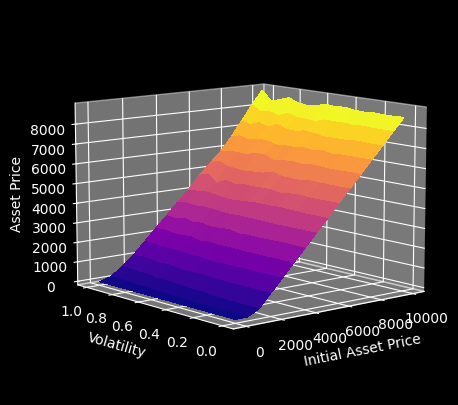

In [47]:
plot_asset_prices(initial_stock_prices, volatilities, classical_results)

### Other mappings

In [12]:
def test_function(a, b, c):
    
    return a + b + c

vmapped_test_function = jax.vmap(test_function,
                                 in_axes = (0, None, 0))

a_s = jnp.array([0, 1])
b_s = 10
c_s = jnp.array([100, 200])

result = vmapped_test_function(a_s, b_s, c_s)

print("Result:", result)

Result: [110 211]


In [13]:
def test_function(arguments):
    
    a, b, c = arguments.values()
    
    return a + b + c

vmapped_test_function = jax.vmap(test_function,
                                 in_axes = ({'a': 0, 'b': None, 'c': 0},))

a_s = jnp.array([0, 1])
b_s = 10
c_s = jnp.array([100, 200])

arguments = {'a': a_s, 'b': b_s, 'c': c_s}

result = vmapped_test_function(arguments)

print("Result:", result)

Result: [110 211]


In [ ]:
vmapped_mc = jax.vmap(monte_carlo,
                      in_axes=(0, None, None, None, None, None, None, None, None))

initial_stock_prices = jnp.array([1000, 2000])
strike_price = 100
volatility = 0.5

result = vmapped_mc(S=initial_stock_prices, 
                     K=strike_price,
                     T=time_to_maturity, 
                     r=risk_free_interest_rate,
                     q=dividend_rate, 
                     sigma=volatility, 
                     CallPut=option_type, 
                     n=time_steps_count,
                     m=paths_count)

print("Result:", result)

# ,
                                # axis_name='filters',
                                # static_broadcasted_argnums=[2, 3, 4, 6, 7, 8],
                                # in_axes=(None, 0, None),
                               # )
    
#     result = vmapped_function()
    
#     result = vmapped_function(S=initial_stock_prices, 
#                                   K=strike_prices,
#                                   T=time_to_maturity, 
#                                   r=risk_free_interest_rate,
#                                   q=dividend_rate, 
#                                   sigma=volatilities, 
#                                   CallPut=option_type, 
#                                   n=time_steps_count,
#                                   m=paths_count)
    
#     continue